# Contingency analysis

We can define N-1 cases to be analyzed as contingencies. This means that indices of _net.line_, _net.trafo_, _net.trafo3w_ can be defined as contingencies, which are switched off one at a time. The power system is analyzed with power flow calculations, and the min/max values among all the N-1 cases are obtained for relevant variables.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pandapower.networks import case9
from pandapower.contingency import run_contingency, get_element_limits, check_elements_within_limits, report_contingency_results, run_contingency_ls2g
from pandapower.timeseries import DFData, OutputWriter, run_timeseries
from pandapower.control import ConstControl
from pandapower.toolbox.grid_modification import replace_ext_grid_by_gen
from pandapower.plotting.plotting_toolbox import set_line_geodata_from_bus_geodata

A dictionary that defines all the relevant N-1 cases to be analyzed is a required input parameter. Further parameters are:

* _pf_options_: dict with keyword arguments for the power flow function only for the N-0 condition
* _pf_options_nminus1_: dict with keyword arguments for the power flow function only for the N-1 situations
* _write_to_net_: whether to write the results of contingency analysis to net (in "res_" tables), default True
* _contingency_evaluation_function_: function to use for power flow calculation, default pp.runpp
* _kwargs_: additional keyword arguments passed to the power flow function for  N-0 and N-1 situations

The results of the contingency analysis are returned as a dictionary, and also written in the results tables in net:

In [2]:
net = case9()

nminus1_cases = {"line": {"index": net.line.index.values}}
res = run_contingency(net, nminus1_cases)

The results can be evaluated with the fuction _check\_elements\_within\_limits_. 

It uses the required input _element\_limits_, which is a dictionary with limit values for all the relevant limits. Elements with at least one limit variable set as not _nan_ are considered relevant, and elements with all limit variables set to _nan_ are ignored. 

The function returns True if all results are within specified limits, and False in case of any violations:

In [3]:
element_limits = get_element_limits(net)
check_elements_within_limits(element_limits, res, True)

False

The contingency analysis determined violations of limits. The function _report\_contingency\_results_ can be used to print logging statements, informing the user of the details of the limit violations:

In [4]:
report_contingency_results(element_limits, res)

## Time-series simulation

The function _run\_contingency_ can be passed to _run_timeseries_. 

The parameters for _run\_contingency_ can be passed as kwargs to the _run\_timeseries_ function as the parameter _run\_control\_fct_. Note: avoid passing it as the _run_ argument, because it will cause multiple contingency calculations per time step if there are any controllers in the grid model. Here we pass _nminus1\_cases_ as a keyword argument, which is passed to run_contingency during time-series simulation.

This way, the contingency analysis is executed at every timne step of the time-series simulation. The results of the contingency analysis for every time step can be added to the output of the _output\_writer_ and analyzed after the time-series calculation.

First, we configure the time-series simulation:

In [5]:
load_profiles = pd.DataFrame(net.load.p_mw.values * (np.random.random((24, len(net.load))) * 0.4 + 0.8), index=np.arange(24), columns=net.load.index.values)
dsl = DFData(load_profiles)
ConstControl(net, element="load", variable="p_mw", element_index=net.load.index.values,
                        profile_name=net.load.index.values, data_source=dsl)


gen_profiles = pd.DataFrame(net.gen.p_mw.values * (np.random.random((24, len(net.gen))) * 0.4 + 0.8), 
                             index=np.arange(24), columns=net.gen.index.values)
dsg = DFData(gen_profiles)
ConstControl(net, element="gen", variable="p_mw", element_index=net.gen.index.values,
                        profile_name=net.gen.index.values, data_source=dsg)

ow = OutputWriter(net)
ow.log_variable("res_line", "max_loading_percent")
ow.log_variable("res_line", "min_loading_percent")
ow.log_variable("res_bus", "max_vm_pu")
ow.log_variable("res_bus", "min_vm_pu")

The time-series simulation is executed:

In [6]:
run_timeseries(net, time_steps=range(24), run_control_fct=run_contingency, nminus1_cases=nminus1_cases)

100%|██████████| 24/24 [00:05<00:00,  4.33it/s]


We can aggregate the result values from the output writer and show the max. and min. values for the N-0 and N-1 situations for every time step:

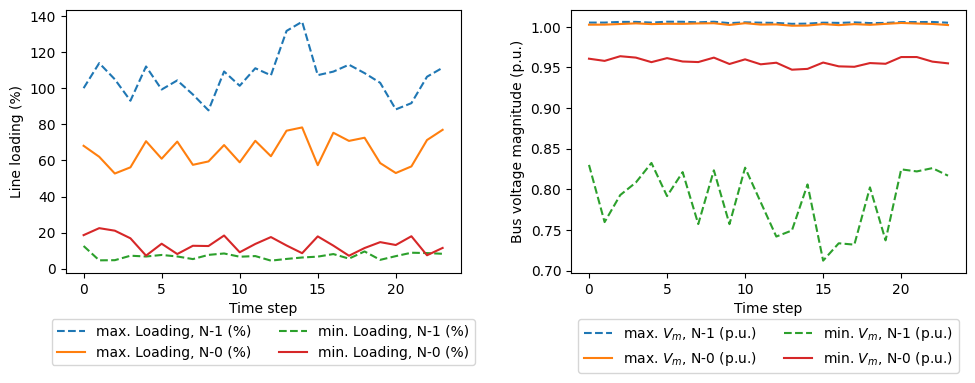

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10,4))

ow.output["res_line.max_loading_percent"].max(axis=1).plot(label="max. Loading, N-1 (%)", ax=ax1, linestyle="--")
ow.output["res_line.loading_percent"].max(axis=1).plot(label="max. Loading, N-0 (%)", ax=ax1)
ow.output["res_line.min_loading_percent"].min(axis=1).plot(label="min. Loading, N-1 (%)", ax=ax1, linestyle="--")
ow.output["res_line.loading_percent"].min(axis=1).plot(label="min. Loading, N-0 (%)", ax=ax1)

ax1.legend(ncol=2, loc="upper center", bbox_to_anchor=[0.5, -0.15])
ax1.set_ylabel("Line loading (%)")
ax1.set_xlabel("Time step")

ow.output["res_bus.max_vm_pu"].max(axis=1).plot(label="max. $V_m$, N-1 (p.u.)", ax=ax2, linestyle="--")
ow.output["res_bus.vm_pu"].max(axis=1).plot(label="max. $V_m$, N-0 (p.u.)", ax=ax2)
ow.output["res_bus.min_vm_pu"].min(axis=1).plot(label="min. $V_m$, N-1 (p.u.)", ax=ax2, linestyle="--")
ow.output["res_bus.vm_pu"].min(axis=1).plot(label="min. $V_m$, N-0 (p.u.)", ax=ax2)

ax2.legend(ncol=2, loc="upper center", bbox_to_anchor=[0.5, -0.15])
ax2.set_ylabel("Bus voltage magnitude (p.u.)")
ax2.set_xlabel("Time step")

plt.tight_layout()

A more advanced plotting of results using boxplot provides more insight into every time step:

In [8]:
def plot_results_boxplots():
    fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(ncols=2, nrows=2, sharey="row", sharex="col", figsize=(10,6))

    ow.output["res_line.max_loading_percent"].T.boxplot(ax=ax11, whis=[0,100], grid=False)
    ax11.set_title("max. Loading of lines per time step, N-1 (%)")
    ax11.set_ylabel("Line loading (%)")

    ow.output["res_line.min_loading_percent"].T.boxplot(ax=ax12, whis=[0,100], grid=False)
    ax12.set_title("min. Loading of lines per time step, N-1 (%)")

    ow.output["res_bus.max_vm_pu"].T.boxplot(ax=ax21, whis=[0,100], grid=False)
    ax21.set_title("max. $V_m$ of buses per time step, N-1 (p.u.)")
    ax21.set_ylabel("Bus voltage magnitude (p.u.)")
    ax21.set_xlabel("Time step")

    ow.output["res_bus.min_vm_pu"].T.boxplot(ax=ax22, whis=[0,100], grid=False)
    ax22.set_title("min. $V_m$ of buses per time step, N-1 (p.u.)")
    ax22.set_xlabel("Time step")

    plt.tight_layout()

## Speed-up with lightsim2grid

The library lightsim2grid implements its own contingency analysis function in C++, which provides at least a magnitude of performance improvement in comparison to the pandapower function. The caveats are that not all possible features (e.g. trafo3w) of pandapower grid modeling are compatible with this particular implementation, and that buses must have a continuous index starting with 0. If the pandapower grid model has incompatible features, a warning is shown. 

Furthermore, there can be a difference in results between pandapower and lightsim2grid calculations due to some implementation differences. The results of the contingency analysis are related to the "from_bus" of lines and the "hv_bus" of transformers in lightsim2grid, but in pandapower the maximum value between "from_bus" and "to_bus" ("hv_bus" and "lv_bus") is used. In addition, if a contingency leads to an isolated island in the grid, the results for the contingency are set to _nan_ in lightsim2grid. However, pandapower selects a _gen_ element authomatically in such an isolated island as a new slack, and has values as results for such a contingency. 

If the pandapower grid model has an _ext\_grid_ element as slack (as is most commonly the case), lightsim2grid will show warnings that it will attempt to use it as a slack generator. In order to avoid such warnings, we advise converting the _ext\_grid_ element to a _gen_ element with True for _slack_ parameter and set the _slack\_weight_ parameter to 1. This can be accomplished using the convenience function `pandapower.toolbox.replace_ext_grid_by_gen()`.

It is important to know about these differences and consider them in configuring the calculation and in the analysis of the results. In the following example, we demonstrate the use of this function.

In [9]:
gen_index = replace_ext_grid_by_gen(net, slack=True, cols_to_keep=["slack_weight"])
run_timeseries(net, time_steps=range(24), run_control_fct=run_contingency_ls2g, nminus1_cases=nminus1_cases)

100%|██████████| 24/24 [00:00<00:00, 30.06it/s]


The performance improvement is evident from comparing the number of iterations per second between the time-series simulations. We can observe an improvement of about 6 times here. However, a much higher improvement can be expected with larger grids.

The difference in results is obvious from looking at the plots below. This is not due to any errors but due to the aforementioned differences in the implementation. We strongly advise knowing exactly what those differences are when using this function.

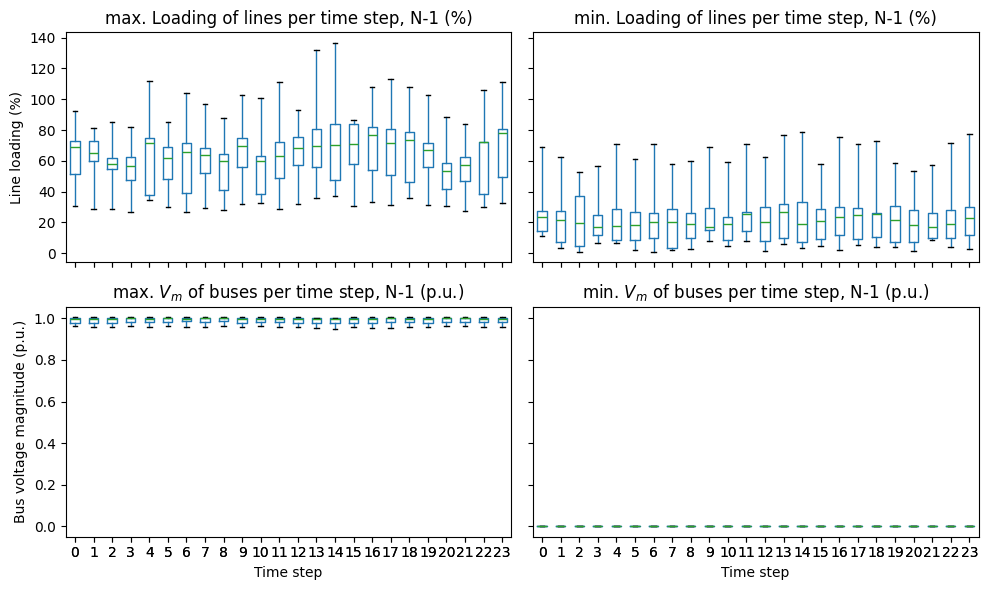

In [10]:
plot_results_boxplots()

# Cause elements

In addition to the impact of contingencies on the grid, it is also interesting to include the focus on the causes of the contingencies. The columns _causes\_overloading_, _cause\_element_, and _cause\_index_ describe which element ("line" or "trafo") caused the highest loading of the line. In the following example we color the lines according to the metric of how often they cause the highest overloading of other lines. This is useful to identify the most critical lines. The function run_contingency_ls2g additionally outputs the overall grid congestion caused by the failure of each elements i.e. for every N-1 case, which is useful to evaluate how critical any element is to the overall grid.

In [11]:
set_line_geodata_from_bus_geodata(net)
net.load.p_mw = [125, 150, 175]
run_contingency_ls2g(net, nminus1_cases)
d = pd.DataFrame(net.res_line.groupby("cause_index")["cause_index"].count())
net.line["cause_number"] = 0
net.line.loc[d.index, "cause_number"] = d.cause_index.values

Three lines are responsible for the highest loadings of other lines, and the line 5 has that role the most times.

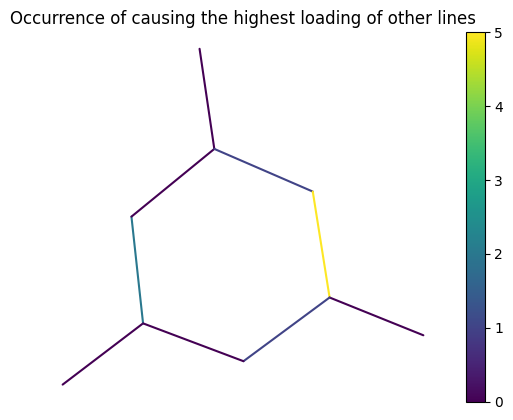

In [12]:
import geopandas as gpd
import geojson

net.line.geo = net.line.geo.apply(lambda x: geojson.loads(x))
net.line = gpd.GeoDataFrame(net.line, geometry='geo')

ax = net.line.plot(column=net.line.cause_number, legend=True)
ax.set_title("Occurrence of causing the highest loading of other lines")
ax.set_axis_off();

The lines that cause the highest congestion in case of their failure can be represented graphically as demonstrated below. Also in this case the line 5 is the most critical.

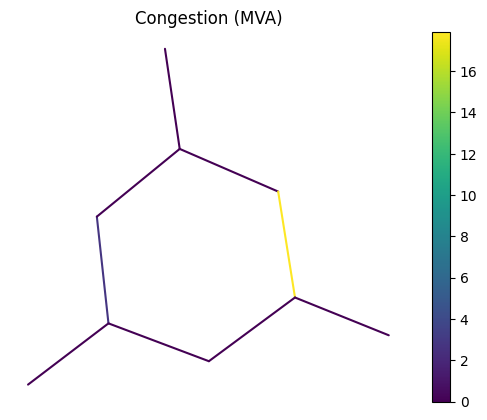

In [13]:
ax = net.line.plot(column=net.res_line.congestion_caused_mva, legend=True)
ax.set_title("Congestion (MVA)")
ax.set_axis_off();